# MordenBert

## Load data, prepare for training

Notes:
- The sentences are seperated by space token by token
- token index starts from 0


In [18]:
import pandas as pd

# Rename columns
col_names = [
    "sentence1",
    "e1_trigger_start",
    "e1_trigger_end",
    "e1_participant1_start",
    "e1_participant1_end",
    "e1_participant2_start",
    "e1_participant2_end",
    "e1_time_start",
    "e1_time_end",
    "e1_loc_start",
    "e1_loc_end",
    "sentence2",
    "e2_trigger_start",
    "e2_trigger_end",
    "e2_participant1_start",
    "e2_participant1_end",
    "e2_participant2_start",
    "e2_participant2_end",
    "e2_time_start",
    "e2_time_end",
    "e2_loc_start",
    "e2_loc_end",
    "label"
]

# Load data
with open("../data/event_pairs.train") as f:
    lines = f.readlines()
    lines = [l.strip().split("\t") for l in lines]
    train_set = pd.DataFrame(lines, columns=col_names)

with open("../data/event_pairs.dev") as f:
    lines = f.readlines()
    lines = [l.strip().split("\t") for l in lines]
    dev_set = pd.DataFrame(lines, columns=col_names)

with open("../data/event_pairs.test") as f:
    lines = f.readlines()
    lines = [l.strip().split("\t") for l in lines]
    test_set = pd.DataFrame(lines, columns=['event_id_1', 'event_id_2'] + col_names)


# Drop columns since most of them are -1 which is not provided by the dataset
for dataset in [train_set, dev_set, test_set]:
    dataset.drop(columns=['e1_participant1_start', 'e1_participant1_end', 'e1_participant2_start', 'e1_participant2_end', 'e1_time_start', 'e1_time_end', 'e1_loc_start', 'e1_loc_end', 'e2_participant1_start', 'e2_participant1_end', 'e2_participant2_start', 'e2_participant2_end', 'e2_time_start', 'e2_time_end', 'e2_loc_start', 'e2_loc_end'], inplace=True)

In [28]:
# check if there is any missing data
# print(train_set.isnull().sum())
# print(dev_set.isnull().sum())
# print(test_set.isnull().sum())

# check if there is any index equal to -1 or start index greater than end index
print(train_set[train_set['e1_trigger_start'] == '-1'])
print(train_set[train_set['e2_trigger_start'] == '-1'])
print(train_set[train_set['e1_trigger_start'] > train_set['e1_trigger_end']])
print(train_set[train_set['e2_trigger_start'] > train_set['e2_trigger_end']])


Empty DataFrame
Columns: [sentence1, e1_trigger_start, e1_trigger_end, sentence2, e2_trigger_start, e2_trigger_end, label]
Index: []
Empty DataFrame
Columns: [sentence1, e1_trigger_start, e1_trigger_end, sentence2, e2_trigger_start, e2_trigger_end, label]
Index: []
Empty DataFrame
Columns: [sentence1, e1_trigger_start, e1_trigger_end, sentence2, e2_trigger_start, e2_trigger_end, label]
Index: []
Empty DataFrame
Columns: [sentence1, e1_trigger_start, e1_trigger_end, sentence2, e2_trigger_start, e2_trigger_end, label]
Index: []


In [34]:
# convert to int and str
train_set = train_set.astype({'e1_trigger_start': 'int', 'e1_trigger_end': 'int', 'e2_trigger_start': 'int', 'e2_trigger_end': 'int', 'label': 'int', 'sentence1': 'str', 'sentence2': 'str'})
dev_set = dev_set.astype({'e1_trigger_start': 'int', 'e1_trigger_end': 'int', 'e2_trigger_start': 'int', 'e2_trigger_end': 'int', 'label': 'int', 'sentence1': 'str', 'sentence2': 'str'})
test_set = test_set.astype({'e1_trigger_start': 'int', 'e1_trigger_end': 'int', 'e2_trigger_start': 'int', 'e2_trigger_end': 'int', 'sentence1': 'str', 'sentence2': 'str'})

print(train_set.dtypes)

sentence1           object
e1_trigger_start     int64
e1_trigger_end       int64
sentence2           object
e2_trigger_start     int64
e2_trigger_end       int64
label                int64
dtype: object


In [35]:
def extract_trigger(row, i: str):
    try:
        trigger_start = row[f'e{i}_trigger_start']
        trigger_end = row[f'e{i}_trigger_end']
        
        # Check for NaN values
        if pd.isna(trigger_start) or pd.isna(trigger_end):
            return None
            
        start_idx = int(trigger_start)
        end_idx = int(trigger_end)
        
        sentence = row[f'sentence{i}']
            
        words = sentence.split()
        if start_idx >= 0 and end_idx < len(words):
            return words[start_idx: end_idx + 1][0]
        else:
            raise ValueError("Trigger indices out of bounds")
        
    except Exception as e:
        print(f"Error in row {row.name}: {str(e)}")
        return None

for dataset in [train_set, dev_set, test_set]:
    dataset['e1_trigger'] = dataset.apply(lambda row: extract_trigger(row, 1), axis=1)
    dataset['e2_trigger'] = dataset.apply(lambda row: extract_trigger(row, 2), axis=1)
    dataset['length'] = dataset.apply(lambda row: len(row['sentence1'].split()) + len(row['sentence2'].split()), axis=1)

        

In [36]:
for dataset in [train_set, dev_set, test_set]:
    dataset.drop(columns=['e1_trigger_start', 'e1_trigger_end', 'e2_trigger_start', 'e2_trigger_end'], inplace=True)

In [41]:
train_set.sample(10)

,sentence1,sentence2,label,e1_trigger,e2_trigger,length
38991,The central government of China bears the grea...,"-On July 1, rioters blocked major roads in Hon...",0,bears,threw,78
142886,“The girl is under the close attention of doct...,"Several people were arrested , including indiv...",0,attention,tried,60
19980,The episode was captured on cellphone video an...,When the protests over the shooting of Mr. Bla...,1,protests,protests,73
130112,In a separate update regarding incidents durin...,"Several people were arrested , including in Mo...",0,arson,including,86
191979,They emphasized that he was the only person th...,The judge twice admonished Prosecutor Binger f...,0,emphasized,admonished,68
75517,"Analysts say that in the post-election period,...","In Burkina Faso, a daily newspaper summed up t...",0,measures,embodies,80
95517,"""If getting the desired election results still...","Analysts say that in the post-election period,...",0,required,introduce,66
171288,"“You learn the music the judge is playing ,” h...",But jurors can consider whether the defendant ...,0,dance,assess,47
222551,He said that Rosenbaum was going to kill him i...,Two jurors spoke congenially to each other as ...,0,said,spoke,35
49325,The protesters stormed the legislature after t...,"Lee, who started his career in the police and ...",0,vandalised,pinpointed,74


In [42]:
# save the datasets
train_set.to_csv("../data/train_set.csv", index=False)
dev_set.to_csv("../data/dev_set.csv", index=False)
test_set.to_csv("../data/test_set.csv", index=False)

In [46]:
train_set.length.describe()

count    227328.000000
mean         69.869721
std          18.062424
min          13.000000
25%          57.000000
50%          69.000000
75%          81.000000
max         238.000000
Name: length, dtype: float64

In [47]:
train_set[train_set['length'] > 512]

,sentence1,sentence2,label,e1_trigger,e2_trigger,length


## Dataset 

In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from transformers import AutoTokenizer

class CDECDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame, 
                 tokenizer: AutoTokenizer, 
                 max_len=512):
        """
        Args:
            df: DataFrame containing the data
            tokenizer: BERT tokenizer
            max_len (int): Maximum length of tokens
        """
        self.data = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sentence1 = self.data.iloc[idx]['sentence1']
        sentence2 = self.data.iloc[idx]['sentence2']
        trigger1 = self.data.iloc[idx]['e1_trigger']
        trigger2 = self.data.iloc[idx]['e2_trigger']
        label = self.data.iloc[idx]['label']
        
        encoding = self.tokenizer.encode_plus(
            text=sentence1,
            text_pair=sentence2,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

/root/github/CDEC-resolution/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train model

2 implementations:
- directly use ModernBertForSequenceClassification, with default setting
- write my own cls, more customized, (maybe later)

In [27]:
from transformers import AutoTokenizer

# Defining some key variables that will be used later on in the training
MAX_LEN = 300
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 128
EPOCHS = 3
LEARNING_RATE = 1e-05

In [28]:
# load the datasets
train_df = pd.read_csv("../data/train_set.csv")
dev_df = pd.read_csv("../data/dev_set.csv")
test_df = pd.read_csv("../data/test_set.csv")

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
train_dataset = CDECDataset(train_df, tokenizer, max_len=MAX_LEN)
dev_dataset = CDECDataset(dev_df, tokenizer, max_len=MAX_LEN)
test_dataset = CDECDataset(test_df, tokenizer, max_len=MAX_LEN)

In [29]:
# Create the DataLoaders
from torch.utils.data import DataLoader

train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

dev_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

train_loader = DataLoader(train_dataset, **train_params)
dev_loader = DataLoader(dev_dataset, **dev_params)
test_loader = DataLoader(test_dataset, **test_params)



In [10]:
from transformers import ModernBertModel, BertForSequenceClassification, ModernBertForSequenceClassification
import torch
import torch._dynamo
import random
import os
import numpy as np

# 1. Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# 2. Enable deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 3. Add your existing code with seed setting
set_seed(42)


torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')



model = ModernBertForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base", attn_implementation="flash_attention_2")
model.to('cuda')

inputs = tokenizer.encode_plus(
    text="The quick brown fox jumps over the lazy dog",
    text_pair="The quick brown fox jumps over the lazy dog",
    add_special_tokens=True,
    max_length=300,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
).to('cuda')

with torch.no_grad():
    outputs = model(**inputs)

outputs

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SequenceClassifierOutput(loss=None, logits=tensor([[0.1055, 0.3281]], device='cuda:0'), hidden_states=None, attentions=None)

In [72]:
model.config

ModernBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "answerdotai/ModernBERT-base",
  "architectures": [
    "ModernBertForMaskedLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 50281,
  "classifier_activation": "gelu",
  "classifier_bias": false,
  "classifier_dropout": 0.0,
  "classifier_pooling": "mean",
  "cls_token_id": 50281,
  "decoder_bias": true,
  "deterministic_flash_attn": false,
  "embedding_dropout": 0.0,
  "eos_token_id": 50282,
  "global_attn_every_n_layers": 3,
  "global_rope_theta": 160000.0,
  "gradient_checkpointing": false,
  "hidden_activation": "gelu",
  "hidden_size": 768,
  "initializer_cutoff_factor": 2.0,
  "initializer_range": 0.02,
  "intermediate_size": 1152,
  "layer_norm_eps": 1e-05,
  "local_attention": 128,
  "local_rope_theta": 10000.0,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "mlp_dropout": 0.0,
  "model_type": "modernbert",
  "norm_bias": false,
  "norm_eps": 1e-05,
  "num_at

In [73]:
tokenizer.encode_plus(
    text="The quick brown fox jumps over the lazy dog",
    text_pair="The quick brown fox jumps over the lazy dog",
    add_special_tokens=True,
    max_length=300,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

{'input_ids': tensor([[50281,   510,  3158,  8516, 30013, 27287,   689,   253, 22658,  4370,
         50282,   510,  3158,  8516, 30013, 27287,   689,   253, 22658,  4370,
         50282, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 5

In [71]:
# class ModernBertClassifier(torch.nn.Module):
#     def __init__(self, model, num_labels, classifier_pooling="cls"):
#         super(ModernBertClassifier, self).__init__()
#         self.bert = model
#         self.dropout = torch.nn.Dropout(0.2)
#         self.classifier = torch.nn.Linear(model.config.hidden_size, num_labels)
#         self.classifier_pooling = classifier_pooling
        
#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(
#             input_ids=input_ids, 
#             attention_mask=attention_mask
#         )
        
#         last_hidden_state = outputs[0]
        
#         if self.classifier_pooling == "cls":
#             last_hidden_state = last_hidden_state[:, 0]
#         elif self.classifier_pooling == "mean":
#             last_hidden_state = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(
#                 dim=1, keepdim=True
#             )

In [18]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


class LossTracker:
    def __init__(self):
        self.history = defaultdict(list)
        
    def update(self, metrics):
        for k, v in metrics.items():
            self.history[k].append(v)
            
    def plot(self):
        plt.figure(figsize=(10, 6))
        for metric, values in self.history.items():
            plt.plot(values, label=metric)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

In [21]:
# start training
from tqdm import tqdm

def loss_fn(outputs, targets):
    """
    Args:
        outputs: SequenceClassifierOutput from model
        targets: Label tensor
    """
    if hasattr(outputs, 'logits'):
        return torch.nn.CrossEntropyLoss()(outputs.logits, targets)
    return torch.nn.CrossEntropyLoss()(outputs, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# lr_scheduler = torch.optim.lr_scheduler.

def train_fn(data_loader, model, optimizer, scheduler, device):
    model.train()
    final_loss = 0
    progress_bar = tqdm(data_loader, total=len(data_loader), desc="Training")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        final_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs.logits, targets)
            total_loss += loss.item()
            
    return total_loss / len(data_loader)


Epoch 1/3


Evaluating: 100%|██████████| 285/285 [00:31<00:00,  9.08it/s]


Train Loss: 0.1871
Dev Loss: 0.2436

Epoch 2/3


Evaluating: 100%|██████████| 285/285 [00:29<00:00,  9.55it/s]


Train Loss: 0.1492
Dev Loss: 0.2633

Epoch 3/3


Evaluating: 100%|██████████| 285/285 [00:30<00:00,  9.38it/s]


Train Loss: 0.1322
Dev Loss: 0.2488


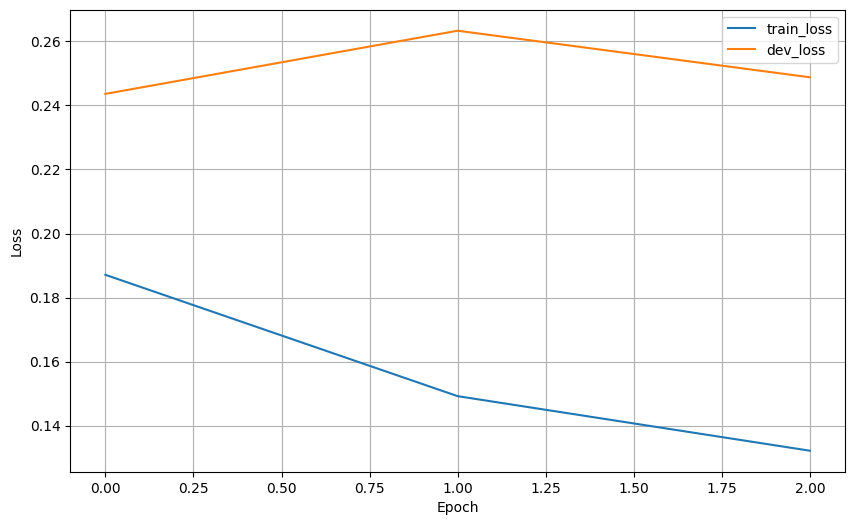

In [30]:
# Training setup
tracker = LossTracker()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
best_loss = float('inf')
# patience = 3
# patience_counter = 0

# Training loop
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train_fn(train_loader, model, optimizer, scheduler, 'cuda')
    dev_loss = eval_fn(dev_loader, model, 'cuda')
    
    tracker.update({
        'train_loss': train_loss,
        'dev_loss': dev_loss
    })
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Dev Loss: {dev_loss:.4f}")
    
    # # Early stopping
    # if dev_loss < best_loss:
    #     best_loss = dev_loss
    #     patience_counter = 0
    #     torch.save(model.state_dict(), 'best_model.pt')
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         break

# Plot loss curves
tracker.plot()

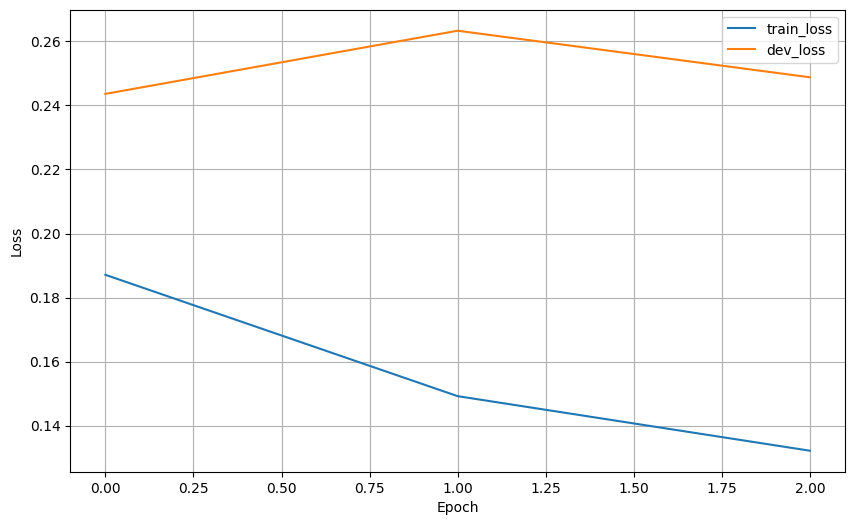

In [31]:
tracker.plot()

## Test model result

In [32]:
# baseline for untrained model

from tqdm import tqdm
from sklearn.metrics import classification_report

model.eval()
preds = []
labels = []
for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to('cuda')
    attention_mask = batch['attention_mask'].to('cuda')
    labels.extend(batch['label'].numpy())
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    
    preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())


100%|██████████| 336/336 [00:44<00:00,  7.52it/s]


In [34]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     39111
           1       0.41      0.35      0.38      3842

    accuracy                           0.90     42953
   macro avg       0.67      0.65      0.66     42953
weighted avg       0.89      0.90      0.89     42953



In [2]:
import pandas as pd
train_df = pd.read_csv("../data/train_set.csv")

# Decoder model

## Dataset

In [113]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "unsloth/Qwen2.5-0.5B-Instruct",
    max_seq_length = 300,
    dtype = None,
    load_in_4bit = False,
)

==((====))==  Unsloth 2025.2.15: Fast Qwen2 patching. Transformers: 4.48.2.
   \\   /|    GPU: NVIDIA GeForce RTX 4080. Max memory: 15.992 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
sentence1 = "Here is what we know about the fighting at and around Al - Shifa medical center that the Israeli army says has killed more than 140 Palestinian militants ."
sentence2 = "Global calls for a humanitarian ceasefire have mounted in recent days as Al - Shifa became the focus of Israel ’s war on Hamas , and fears grew for the thousands of people trapped there , on the frontline of the conflict ."
trigger1 = "fighting"
trigger2 = "conflict"

prompt = (
    f"Task: Determine if two event words refer to the same event.\n"
    f"First sentence: {sentence1}\n"
    f"Event word in first sentence: {trigger1}\n"
    f"Second sentence: {sentence2}\n"
    f"Event word in second sentence: {trigger2}\n"
    f"Question: Do the event words *{trigger1}* and *{trigger2}* refer to the same event?  Answer only with Yes or No.\n"
    f"Answer:"
)

message = [
    {
        "role": "user",
        "content": prompt
    },
    {
        "role": "assistant",
        "content": "Yes"
    }
]

input_ids = tokenizer.apply_chat_template(message, return_tensors="pt").to('cuda')
# tokenizer.decode(tokenizer.apply_chat_template(message, add_generation_prompt=True))

FastLanguageModel.for_inference(model)
output_ids = model.generate(input_ids)
tokenizer.decode(output_ids[0])

'<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nTask: Determine if two event words refer to the same event.\nFirst sentence: Here is what we know about the fighting at and around Al - Shifa medical center that the Israeli army says has killed more than 140 Palestinian militants .\nEvent word in first sentence: fighting\nSecond sentence: Global calls for a humanitarian ceasefire have mounted in recent days as Al - Shifa became the focus of Israel ’s war on Hamas , and fears grew for the thousands of people trapped there , on the frontline of the conflict .\nEvent word in second sentence: conflict\nQuestion: Do the event words *fighting* and *conflict* refer to the same event?  Answer only with Yes or No.\nAnswer:<|im_end|>\n<|im_start|>assistant\nYes<|im_end|>\n<|endoftext|>'

In [170]:
s = tokenizer.apply_chat_template(message, return_tensors="pt", tokenize=False)
tokenizer.encode_plus(s, max_length=300, padding='max_length', truncation=True, return_tensors='pt')

{'input_ids': tensor([[151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654, 151654,
         15165

In [156]:
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

collator = DataCollatorForCompletionOnlyLM(
    response_template="<|im_start|>assistant\n",
    tokenizer=tokenizer,
)

collator([input_ids[0].cpu().numpy()])['labels']
tokenizer.decode([ 9454, 151645,    198])

'Yes<|im_end|>\n'

In [ ]:
from torch.utils.data import Dataset
import torch

class CDECDecoderDataset(Dataset):
    """Dataset for decoder-only models like Qwen / Llama"""
    def __init__(self, df: pd.DataFrame, tokenizer: AutoTokenizer, max_len=512):
        self.data = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, idx):
        sentence1 = self.data.iloc[idx]['sentence1']
        sentence2 = self.data.iloc[idx]['sentence2']
        trigger1 = self.data.iloc[idx]['e1_trigger']
        trigger2 = self.data.iloc[idx]['e2_trigger']
        label = self.data.iloc[idx]['label']
        
        # Create a more informative prompt for event coreference
        prompt = (
            f"Task: Determine if two event words refer to the same event.\n"
            f"First sentence: {sentence1}\n"
            f"Event word in first sentence: {trigger1}\n"
            f"Second sentence: {sentence2}\n"
            f"Event word in second sentence: {trigger2}\n"
            f"Question: Do the event words *{trigger1}* and *{trigger2}* refer to the same event? Answer only with Yes or No.\n"
            f"Answer:"
        )
        
        # Convert label to more meaningful text
        label_text = "Yes" if label == 1 else "No"

        # Create a chat message
        message = [
            {
                "role": "user",
                "content": prompt
            },
            {
                "role": "assistant",
                "content": label_text
            }
        ]
        
        message_chat = tokenizer.apply_chat_template(message, return_tensors="pt", tokenize=False)
        encoding = tokenizer.encode_plus(message_chat, max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

In [ ]:
train_dataset = CDECDecoderDataset(train_df, tokenizer, max_len=300)
examples = [train_dataset[0], train_dataset[1]]
collator(examples)

TypeError: 'dict' object cannot be interpreted as an integer

In [ ]:
tr